<h1> Trabalho parcial 02 - Iris </h1>
<h3> Dupla: Hélio Potelicki e Rennã Tiedt </h3>

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
def remove_background(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

    height = image.shape[0]
    width = image.shape[1]

    mask = np.zeros((height, width), np.uint8)
    canny = cv2.Canny(thresh, 100, 200)
    circles = cv2.HoughCircles(canny, cv2.HOUGH_GRADIENT, 1, 10000, param1=50, param2=30, minRadius=0, maxRadius=0)

    for i in circles[0, :]:
        cv2.circle(mask, (int(i[0]), int(i[1])), int(i[2]), (255, 255, 255), thickness=-1)

    masked_data = cv2.bitwise_and(image, image, mask=mask)

    _, thresh = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    x, y, w, h = cv2.boundingRect(contours[0])
    crop = masked_data[y:y + h, x:x + w]

    return crop


def remove_pupil(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_image, 127, 255, 0)

    M = cv2.moments(thresh)

    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    centroid = (cX, cY)

    dst = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    blur = cv2.GaussianBlur(dst, (5, 5), 0)
    inv = cv2.bitwise_not(blur)
    thresh = cv2.cvtColor(inv, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(thresh, kernel, iterations=1)

    _, thresh1 = cv2.threshold(erosion, 210, 255, cv2.THRESH_BINARY)

    cnts, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    flag = 10000
    final_cnt = None

    for cnt in cnts:
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        distance = abs(centroid[0] - x) + abs(centroid[1] - y)

        if distance < flag:
            flag = distance
            final_cnt = cnt
        else:
            continue

    (x, y), radius = cv2.minEnclosingCircle(final_cnt)

    center = (int(x), int(y))
    radius = int(radius)

    cv2.circle(image, center, radius, (255, 255, 255), thickness=-1)

    return image

<h5> Run </h5>

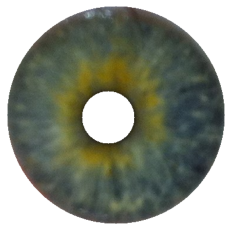

In [17]:
image = cv2.imread('images\iris1.jpg')
image = remove_background(image)
image[np.where((image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
image = remove_pupil(image)

#cv2.imshow("cut", image)
#cv2.waitKey(0)

plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

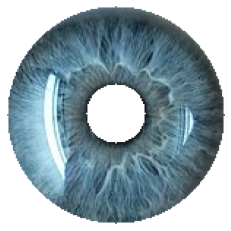

In [18]:
image = cv2.imread('images\iris2.jpg')
image = remove_background(image)
image[np.where((image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
image = remove_pupil(image)

#cv2.imshow("cut", image)
#cv2.waitKey(0)

plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

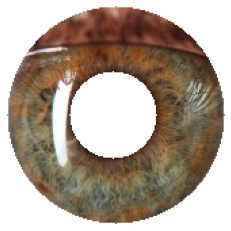

In [19]:
image = cv2.imread('images\iris3.jpg')
image = remove_background(image)
image[np.where((image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
image = remove_pupil(image)

#cv2.imshow("cut", image)
#cv2.waitKey(0)

plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

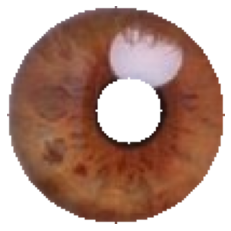

In [20]:
image = cv2.imread('images\iris4.jpg')
image = remove_background(image)
image[np.where((image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
image = remove_pupil(image)

#cv2.imshow("cut", image)
#cv2.waitKey(0)

plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()